<h1> Merging Tables for Data Visualisation </h1>

<h2> 1. Merging Tables </h2>

We need to make sure we have a readable table with each row representing a single player and all features must represent his distinct statistics depending on the period of his career. We want to distinguish the college era and the NBA one in order to calculate the PER in the NBA which will be our target and the college PER which will be an important feature.
        

In [86]:
import pandas as pd

path = "./data/tbls/"

# Charger les datasets
player_history = pd.read_csv(path + "playerHistory.csv")
combine_stats = pd.read_csv(path + "combineStats.csv")
players = pd.read_csv(path + "players.csv")

# Filtrer NCAA et NBA dans playerHistory
ncaa_stats = player_history[player_history["season.stage"] == "ncaa_season"]
nba_stats = player_history[player_history["season.stage"] == "nba_season"]

# Fonction pour calculer le PER
def calculate_per(df):
    return (df["stat.pts"] + df["stat.trb"] + df["stat.ast"] + df["stat.stl"] + df["stat.blk"]
            - (df["stat.fga"] - df["stat.fg"]) - (df["stat.fta"] - df["stat.ft"]) - df["stat.tov"]) / df["stat.minutes"]

# Ajouter le PER aux datasets
ncaa_stats["stat.PERColl"] = calculate_per(ncaa_stats)
nba_stats["stat.PERNBA"] = calculate_per(nba_stats)

# Moyenne du PER et des stats par joueur
ncaa_per = ncaa_stats.groupby("player.id").mean(numeric_only=True).reset_index()
nba_per = nba_stats.groupby("player.id").mean(numeric_only=True).reset_index()


# Fusionner les PER NCAA et NBA
per_data = pd.merge(ncaa_per, nba_per, on="player.id", how="inner", suffixes=("_ncaa", "_nba"))



# Garder toutes les stats physiques depuis combineStats
physical_data = combine_stats.drop(columns=["historical.id", "season.year"]).drop_duplicates(subset=["player.id"])



# Ajouter le nom du joueur
def find_player_name(player_id):
    player = players[players["player.id"] == player_id]
    return player.iloc[0]["player.name"] if not player.empty else None

physical_data["player.name"] = physical_data["player.id"].apply(find_player_name)

# Renommer les colonnes pour plus de clarté
physical_data = physical_data.rename(columns={
    "stat,ht": "height",
    "stat.wt": "weight",
    "stat.wingspan": "wingspan",
    "stat.maxVerLeap": "verticalLeap"
})

# Get rid of all statistics from the NBA except the PER since we want to predict based on NCAA statistics and college players don't have any NBA statistics
# (except the PER)
def remove_nba_stats(df):
    return df[[col for col in df.columns if 'nba' not in col ]]



# Fusionner toutes les stats ensemble
final_df = pd.merge(per_data, physical_data, on="player.id", how="left")
final_df["success"] = final_df["stat.PERNBA"].apply(lambda x: 1 if x > 0.48 else 0)
print("success shape", final_df["success"].shape)
final_df=remove_nba_stats(final_df)



# Sauvegarder le dataset final
final_df.to_csv("full_dataset_model.csv", index=False)

# Print the nba related statistics that figure in the final dataset
print("NBA related statistics in the final dataset:")
print(final_df.columns[final_df.columns.str.contains("nba")].tolist())
print(final_df.head())



C:\Users\PC\AppData\Local\Temp\ipykernel_8172\848628955.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ncaa_stats["stat.PERColl"] = calculate_per(ncaa_stats)
C:\Users\PC\AppData\Local\Temp\ipykernel_8172\848628955.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba_stats["stat.PERNBA"] = calculate_per(nba_stats)


success shape (1461,)
NBA related statistics in the final dataset:
[]
   player.id  historical.id_ncaa  season.year_ncaa  team.id_ncaa  \
0     1866.0             25149.0            2006.0     1103337.0   
1     3562.0            137866.0            2020.5      868271.0   
2     6761.0            115674.0            2018.5     1356740.0   
3    18998.0             19179.0            2004.5     8069604.0   
4    22838.0            126155.0            2019.5     6131757.0   

   stat.games_ncaa  stat.gamesStart_ncaa  stat.minutes_ncaa  stat.fg_ncaa  \
0            28.00                  6.00             452.00         82.00   
1            23.00                 11.50             549.50         80.50   
2            21.75                 19.75             508.25        117.25   
3            32.50                 32.50             976.00        158.00   
4            32.50                 16.50             611.00        138.00   

   stat.fga_ncaa  stat.fgPct_ncaa  ...  stat,bodyFat  stat

<h2> 2. Cleaning up the Data </h2>

We need to clean up the data before doing any visualization or classification : here we are getting rid of rows which have too many missing features, and features that have too many missing values

In [87]:
final_df = pd.read_csv("full_dataset_model.csv")

#dropping player that don't have a name
final_df = final_df[final_df["player.name"].notna()]
#dropping features that are missing more than 40% of the time
missing_threshold = 0.4
missing_columns = final_df.columns[final_df.isnull().mean() > missing_threshold]
final_df = final_df.drop(columns=missing_columns)
#dropping features that are not numeric
numeric_columns = final_df.select_dtypes(include=['number']).columns
final_df = final_df[numeric_columns]
#dropping players that are missing important PERColl stat
final_df = final_df[final_df["stat.PERColl"].notna()]

#printing all the columns and rows that we've dropped
print("Dropped columns:")
print(missing_columns)
print("Dropped rows:")
print(final_df[final_df.isnull().any(axis=1)].shape[0])
#print the shape of the final dataframe
print("Final shape:")
print(final_df.shape)
print("success shape", final_df["success"].shape)   


Dropped columns:
Index(['stat.collBrL', 'stat.collBrR', 'stat.collCornL', 'stat.collCornR',
       'stat.collTop', 'stat.fiftBrL', 'stat.fiftBrR', 'stat.fiftCornL',
       'stat.fiftCornR', 'stat.fiftTop', 'stat.drblCollBrL',
       'stat.drblCollBrR', 'stat.drblCollTop', 'stat.drblFiftBrL',
       'stat.drblFiftBrR', 'stat.drblFiftTop', 'stat.otmColl', 'stat.otmFift',
       'stat.shtlRun', 'stat.benchPress'],
      dtype='object')
Dropped rows:
415
Final shape:
(903, 42)
success shape (903,)


We then need to fill the missing values left and get rid of the infinite value in order to scale our data. We are going to use a StandardScaler and for the missing values, since we're dealing with statistics, using a K-NN imputer fits well because of the context. Indeed, a good analogy would be two players who have similar statistics and therefore have the same archetype, then their 3pts % should be pretty close to eachother if the other features describe a good part of the player's ability of shooting.

In [88]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler


# Convert all 'pd.NA' to 'np.nan'
final_df = final_df.replace([float('inf'), -float('inf')], np.nan)
final_df = final_df.applymap(lambda x: np.nan if pd.isna(x) else x)  # Convert pd.NA to np.nan

# Drop non-numeric columns (Optional: encode them instead)
non_numeric_cols = final_df.select_dtypes(exclude=['number']).columns
if len(non_numeric_cols) > 0:
    print(f"Dropping non-numeric columns: {list(non_numeric_cols)}")
    final_df = final_df.drop(columns=non_numeric_cols)

# Convert all remaining columns to float
final_df = final_df.astype(float)

# Apply KNN Imputer
imputer = KNNImputer(n_neighbors=5)
final_df_imputed = pd.DataFrame(imputer.fit_transform(final_df), columns=final_df.columns)

# Apply Standard Scaler
scaler = StandardScaler()
final_df_scaled = pd.DataFrame(scaler.fit_transform(final_df_imputed), columns=final_df.columns)
  
#printing to see if there are still any inf values
print(final_df_scaled.isin([np.inf, -np.inf]).sum().sum())
print("success shape", final_df_scaled["success"].shape)

0
success shape (903,)


C:\Users\PC\AppData\Local\Temp\ipykernel_8172\701467496.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  final_df = final_df.applymap(lambda x: np.nan if pd.isna(x) else x)  # Convert pd.NA to np.nan


<h2> Data Visualization </h2>

In order to have a good visualization of the data we need classes for our pairplot to have a relevant hue. We are here defining a 'successful' and 'not successful' class based on the NBAPER stat.

['stat.fg2a_ncaa', 'season.year_ncaa', 'stat.stl_ncaa', 'stat,bodyFat', 'stat.threeQuartSprint']


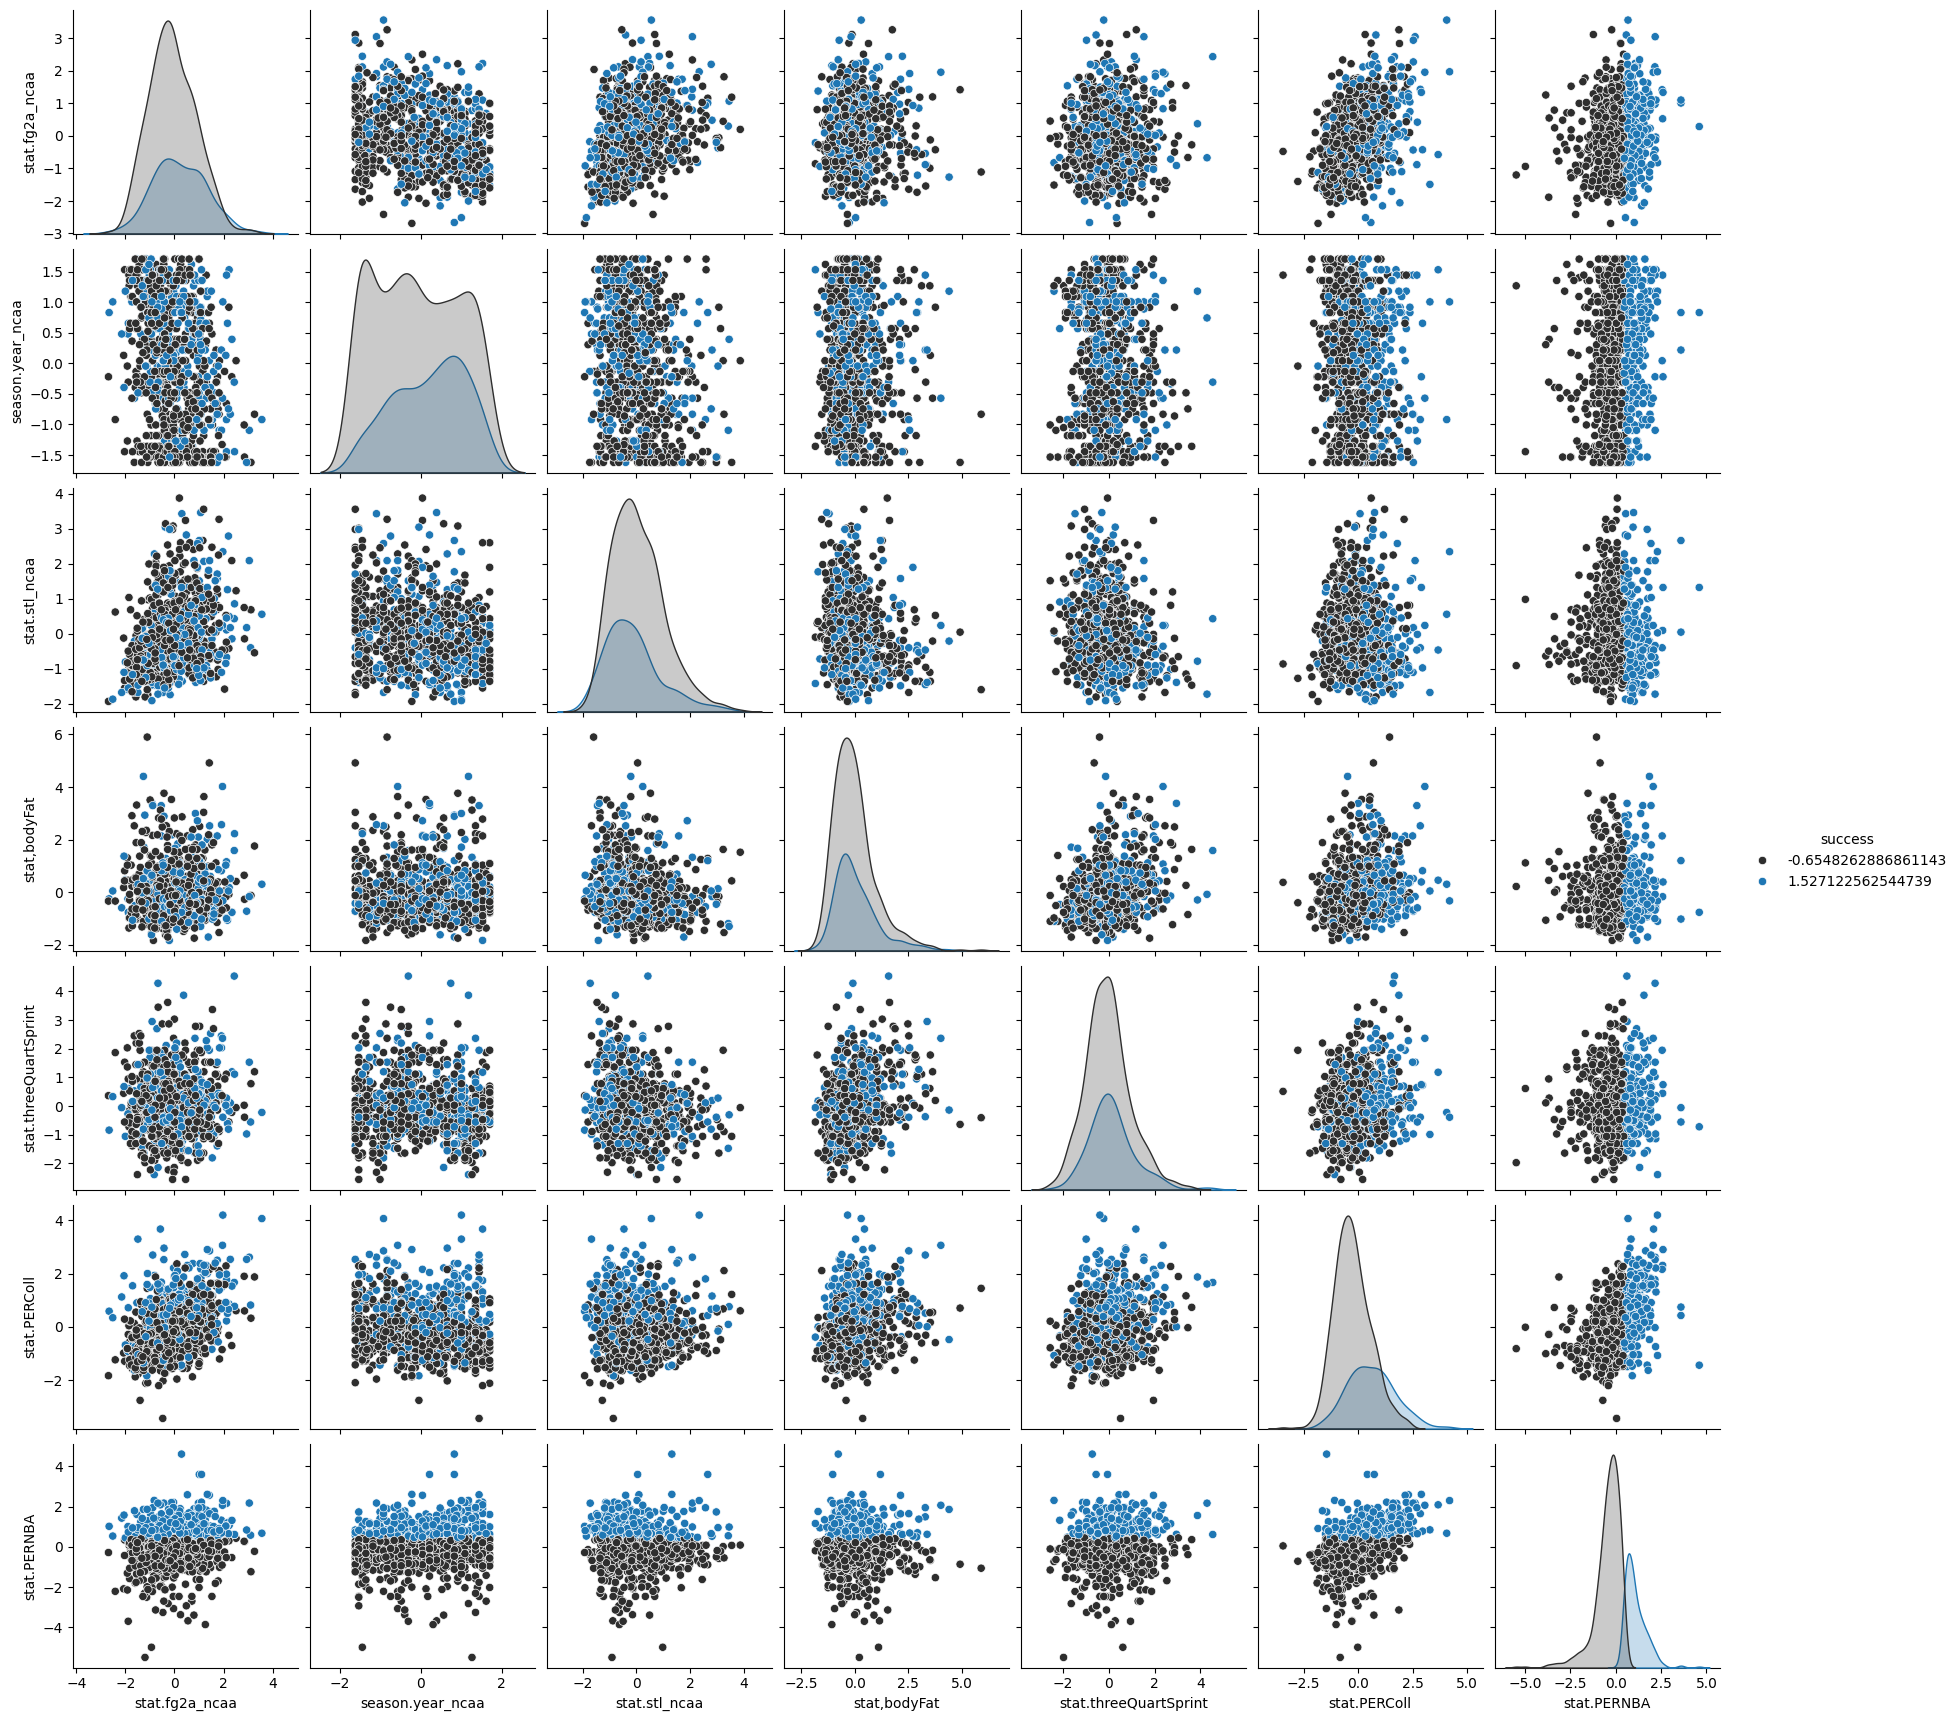

In [90]:
# KDE plot of NCAA PER based on success
#pairplot using only a few random features and the PERs
import seaborn as sns
random_features = final_df_scaled.sample(5, axis=1).columns.tolist()
print(random_features)
random_features.append("stat.PERColl")
random_features.append("stat.PERNBA")
random_features.append("success")
sns.pairplot(final_df_scaled[random_features], hue='success', diag_kind='kde',palette=['#2e2e2e', '#1f77b4'])
plt.savefig("pairplot.png")
plt.show()


We can see in this pairplot that the succesfull and not successfull classes are often clearly separable which means our features will be efficient for our model.

RMSE: 1.09


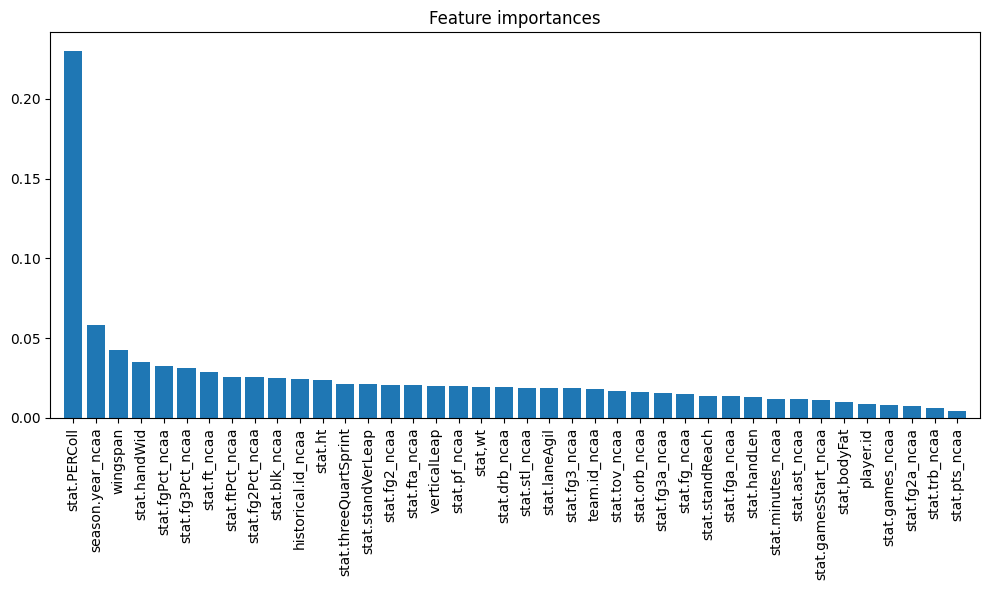

Loaded model RMSE: 1.09
MAE: 0.77
R2: 0.01


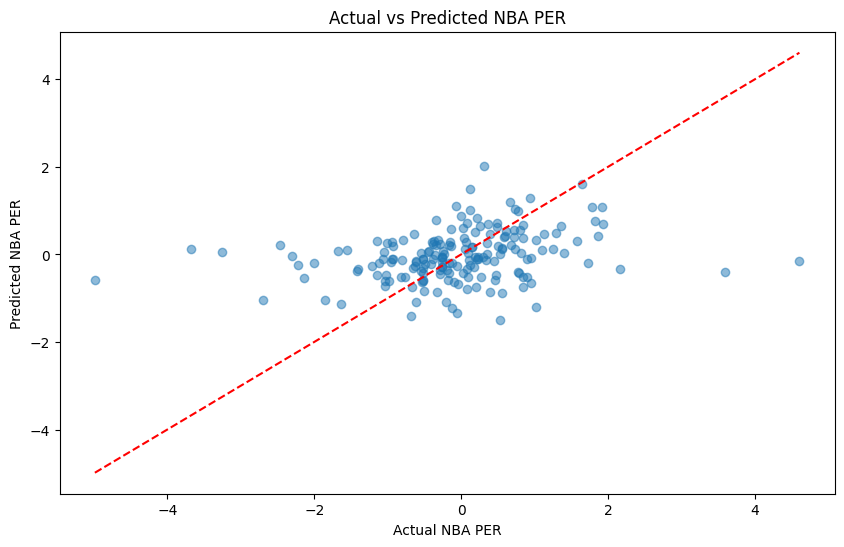

In [91]:
#let's train our model in order to predict a player's NBAPER statistic using a XGBOOST model (regression)
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(final_df_scaled.drop(columns=["stat.PERNBA", "success"]), final_df_scaled["stat.PERNBA"], test_size=0.2, random_state=42)
# Create the XGBoost model
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
# Fit the model
model.fit(X_train, y_train)
# Make predictions
y_pred = model.predict(X_test)
# Calculate RMSE
rmse = sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")
# Plotting feature importance

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train.columns
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), features[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.savefig("feature_importance.png")
plt.show()
# Save the model
model.save_model("xgboost_model.json")
# Load the model
loaded_model = xgb.XGBRegressor()
loaded_model.load_model("xgboost_model.json")
# Make predictions with the loaded model
loaded_y_pred = loaded_model.predict(X_test)
# Calculate RMSE for loaded model
loaded_rmse = sqrt(mean_squared_error(y_test, loaded_y_pred))
print(f"Loaded model RMSE: {loaded_rmse:.2f}")
# Save the final dataset
final_df_scaled.to_csv("final_dataset.csv", index=False)

#trying other metrics
from sklearn.metrics import mean_absolute_error, r2_score
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MAE: {mae:.2f}")
print(f"R2: {r2:.2f}")

# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual NBA PER")
plt.ylabel("Predicted NBA PER")
plt.title("Actual vs Predicted NBA PER")
plt.savefig("actual_vs_predicted.png")
plt.show()



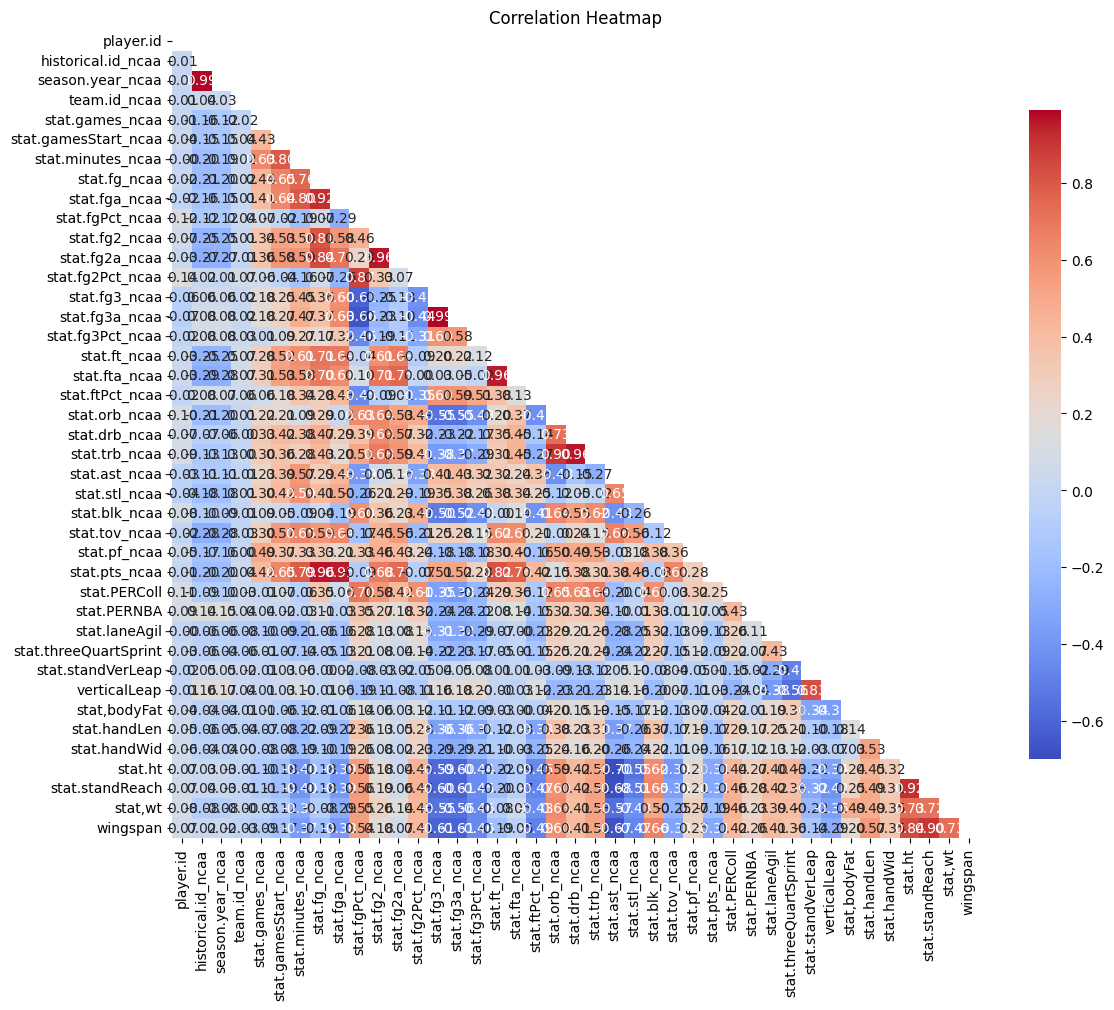

In [92]:
#since these results are not very good let's plot the correlation heatmap of the features and the PERs

heatmap_data = final_df_scaled.drop(columns=["success"])
# Calculate the correlation matrix
corr = heatmap_data.corr()
# Set up the matplotlib figure
plt.figure(figsize=(12, 10))
# Draw the heatmap with the mask and correct aspect ratio
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap="coolwarm", annot=True, fmt=".2f", square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig("correlation_heatmap.png")
plt.show()

